In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/data.zip # Décompresser votre base de données à partir du Drive

Archive:  /content/data.zip
   creating: data/
   creating: data/TEST/
  inflating: data/TEST/chokri12.jpg  
  inflating: data/TEST/chokri13.jpg  
   creating: data/TRAIN/
   creating: data/TRAIN/normal/
  inflating: data/TRAIN/normal/ayoub1.jpg  
  inflating: data/TRAIN/normal/baff3.jpg  
  inflating: data/TRAIN/normal/bilel.jpg  
  inflating: data/TRAIN/normal/chokri4.jpg  
  inflating: data/TRAIN/normal/chokri6.jpg  
  inflating: data/TRAIN/normal/hbiba1.jpg  
  inflating: data/TRAIN/normal/Houssem1.jpg  
  inflating: data/TRAIN/normal/info1.jpg  
  inflating: data/TRAIN/normal/info11.jpg  
  inflating: data/TRAIN/normal/info18.jpg  
  inflating: data/TRAIN/normal/info26.jpg  
  inflating: data/TRAIN/normal/info5.jpg  
  inflating: data/TRAIN/normal/info6.jpg  
  inflating: data/TRAIN/normal/jiji1.jpg  
  inflating: data/TRAIN/normal/lititia1.jpg  
  inflating: data/TRAIN/normal/majdi1.jpg  
  inflating: data/TRAIN/normal/malek3.jpg  
  inflating: data/TRAIN/normal/marwa1.jpg  
  in

In [ ]:
import os
print('total Validation tired images:', len(os.listdir('/content/data/VAL/tired')))
print('total Validation normal images:', len(os.listdir('/content/data/VAL/normal')))
print('total Training tired images:', len(os.listdir('/content/data/TRAIN/tired')))
print('total Training normal images:', len(os.listdir('/content/data/TRAIN/normal')))

total Validation tired images: 5
total Validation normal images: 5
total Training tired images: 20
total Training normal images: 22


In [ ]:
train_dir = '/content/data/TRAIN'
validation_dir = '/content/data/VAL'

In [ ]:
# Architecture CNN
from tensorflow.keras.models import Sequential
from keras import layers
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
model = Sequential()
model.add(layers.Conv2D(256, (3, 3), activation='relu',input_shape=(227, 227, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='sigmoid'))
model.add(layers.Dense(1, activation='sigmoid')) # Dans le cas d'une classification binaire, On met "Dense=1" 
                                                # pour avoir un seul Neurone à la sortie qui va nous donner une valeur 
                                                # compris entre 0 et 1, Si (valeur < 0.5) c'est la "class 0" sinon c'est la "class 1" 
 # NB: la class 0 qui apparaît la premiere dans l'arborescence (dans notre cas c'est la class normal) et class 1 c'est tired

In [ ]:
model.summary() # un moyen de résumer textuel un modèle :  Les couches et leur ordre dans le modèle. La forme de sortie de chaque couche. Le nombre de paramètres (poids) dans chaque couche ici 3,141,505.

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 225, 225, 256)     7168      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 112, 112, 256)    0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 110, 110, 256)     590080    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 55, 55, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 53, 53, 64)        147520    
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 26, 26, 64)      

In [ ]:
# Phase d'augmentation: data augmentation
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   zoom_range=0.4,
                                   horizontal_flip=False,
                                   vertical_flip=True,
                                   fill_mode='nearest')
Val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(227, 227),
    batch_size=1,
    class_mode='binary')
validation_generator = Val_datagen.flow_from_directory(
    validation_dir,
    target_size=(227, 227),
    batch_size=1,
    class_mode='binary')

Found 42 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [ ]:
# Phase d'apprentissage
early = EarlyStopping(monitor='val_loss', mode='min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = model.fit(train_generator,epochs=25, validation_data=validation_generator, callbacks=callbacks_list)

Epoch 1/25
42/42 [==============================] - 2s 46ms/step - loss: 4.2692 - accuracy: 0.5238 - val_loss: 3.4630 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/25
42/42 [==============================] - 2s 42ms/step - loss: 2.4835 - accuracy: 0.5238 - val_loss: 1.6947 - val_accuracy: 0.5000 - lr: 0.0010


In [ ]:
#Sauvgarder notre model
model.save_weights("modelscratch.h5") # enregistre uniquement les poids dans un seul fichier HDF5
print("Saved model to disk")

Saved model to disk


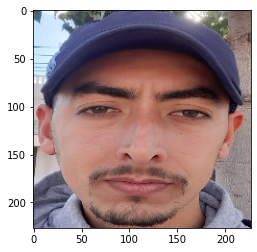

Predicted: [[0.03494978]] normal


In [ ]:
# Phase de test : la projection de la nouvelle image sur notre model
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
img_path='/content/data/TEST/chokri13.jpg'
img = image.load_img(img_path, target_size=(227, 227))
plt.imshow(img)
plt.show()
img = image.img_to_array(img)
x = np.expand_dims(img, axis=0) * 1./255  # 
                                          # rescale 
score = model.predict(x)
print('Predicted:', score, 'normal' if score < 0.5 else 'tired')

In [ ]:
# La 2eme Méthode : "transfer learning" on utilise des poids d'une architecture CNN deja prete sur une base img Net
# => L'architecture "VGG19"  
from tensorflow.keras import applications
from keras.models import Sequential
from keras.layers import Dropout,Dense,Conv2D,GlobalAveragePooling2D
from keras.models import Model
img_width,img_height=224,224  # default input size for the model VGG19 => Resizing data 224 224
base_model =applications.VGG19(weights='imagenet',include_top=False,input_shape=(img_width,img_height,3))
top_model=Sequential()
top_model.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:],data_format=None))
top_model.add(Dense(256,activation='relu'))
top_model.add(Dropout(0.25))
top_model.add(Dense(1,activation='sigmoid'))
modeltransfer=Model(inputs=base_model.input,outputs=top_model(base_model.output))

In [ ]:
# Phase d'apprentissage de la methode "transfer learning"
early = EarlyStopping(monitor='val_loss', mode='min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]
modeltransfer.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = modeltransfer.fit(train_generator,epochs=25, validation_data=validation_generator, callbacks=callbacks_list)

Epoch 1/25
42/42 [==============================] - 4s 61ms/step - loss: 71.1993 - accuracy: 0.5476 - val_loss: 1.1239 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/25
42/42 [==============================] - 2s 53ms/step - loss: 0.8364 - accuracy: 0.4524 - val_loss: 0.9098 - val_accuracy: 0.5000 - lr: 0.0010


In [ ]:
modeltransfer.save_weights("modelTransfer.h5")
print("Saved model to disk")

Saved model to disk


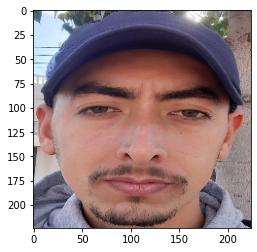

Predicted: [[0.20289163]] normal


In [ ]:
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
img_path='/content/data/TEST/chokri13.jpg'
img = image.load_img(img_path, target_size=(224,224))
plt.imshow(img)
plt.show()
img = image.img_to_array(img)
x = np.expand_dims(img, axis=0) * 1./255
score = modeltransfer.predict(x)
print('Predicted:', score, 'normal' if score < 0.5 else 'tired')